অনেক তো ছোট ছোট ডুব দিলাম । চলেন একটা বড় ডুব দেই ! আমি নিজেও জানিনা এই বড় ডুবে আমার রেজাল্ট কতোটা ভালো আসবে । কিন্তু এটাই বেস্ট প্র্যাকটিস । এখানে আমরা ডেটা সাইন্সের অতি দরকারি ব্যাসিকগুলো নিয়ে কাজ করবো । 
ফিচার ইঞ্জিনিয়ারিং এবং ফিচার সিলেকশন খুবই দরকারি জিনিস ডেটা সাইন্সে । এর আগে আমরা ডিরেক্ট প্রেডিকশনে গিয়েছি । কিন্তু এবার আমরা ক্রস ভ্যালিডেশন করে তারপরে প্রেডিকশনে যাবো । একই সাথে আমরা ডিসিশন ট্রির সাথে সাথে র‍্যান্ডম ফরেস্ট মডেল ট্রেইন করে দেখবো কিরকম আসে রেজাল্ট । যাতে আমাদের হাতে বেস্ট মডেল সিলেক্ট করার অপশন থাকে । 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # Apply the default seaborn theme, scaling, and color palette

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [44]:
df = pd.read_csv("train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [46]:
numerical = ['Age']
categorical = ['Cabin','Embarked']
for num in numerical:
    df[num].fillna(df[num].median(),inplace=True)

for cat in categorical:
    df[cat].fillna(df[cat].value_counts().index[0],inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

এখানেও যার যার কলামের মেডিয়ান (নিউমেরিক্যাল গুলোতে), এবং মোড(ক্যাটাগরিক্যাল গুলোতে) দিয়ে নাল ফিক্স করেছি । 

In [47]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [48]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [49]:
numerical = ['Age','Fare']
categorical = ['Cabin']
for num in numerical:
    test[num].fillna(test[num].median(),inplace=True)

for cat in categorical:
    test[cat].fillna(test[cat].value_counts().index[0],inplace=True)
test.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

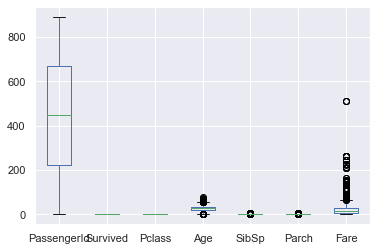

In [50]:
df.plot(kind='box')
plt.show()

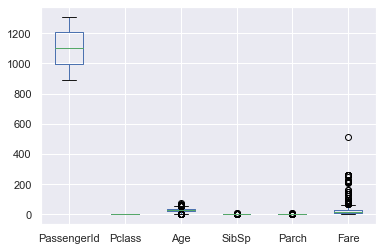

In [51]:
test.plot(kind='box')
plt.show()

২ ডেটাসেটেরই ভাড়ার ফিল্ডে অনেক আউটলেয়ার!

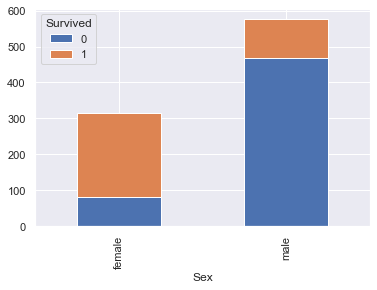

In [52]:
plot = (df
        .groupby(['Sex', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

আমাদের আগের ট্রাইগুলোতে আমরা কোন ফিচার ইঞ্জিনিয়ারিং করি নি । এখানে সেটা শুরু । আমরা যদি আমাদের ডেটাসেটের দিকে তাকাই তাহলে দেখবো যে আমাদের কিন্তু মহিলারা বেশি বেঁচে ছিলেন এবং যারা মা ছিলেন তারা মহিলাদের ভিতর বেশি বেঁচে ছিলেন । 
তাই আমরা এখানে প্যাসেঞ্জারদের নাম থেকে তাদের টাইটেল বের করে নেবো । 

In [53]:
train_test_data = [df, test] 

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [54]:
df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Jonkheer      1
Mme           1
Capt          1
Don           1
Ms            1
Lady          1
Countess      1
Sir           1
Name: Title, dtype: int64

তো এখানে দেখতে পাচ্ছি আমাদের কোন ধরনের লোক কতজন ছিলেন জাহাজে । বিবাহিতা মহিলা দেখা যাচ্ছে 125 জন । 

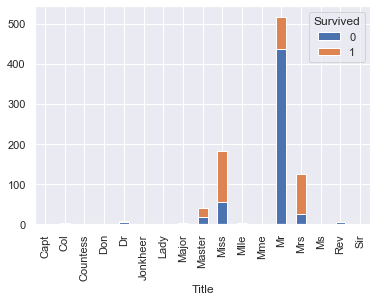

In [56]:
plot = (df
        .groupby(['Title', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

উপরের কথার প্রমাণ পেলেন কি? মহিলারা বেশি বেঁচেছেন । এবং বিবাহিতা মহিলারা বেশি বেঁচেছিলেন তাদের ভিতরে । কারণ বাচ্চাদের সাথে মায়েদের বাঁচানো জরুরি ছিলো ।

In [59]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [60]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

এবার আমরা তাদের টাইটেলের বিপরীতে নিউমেরিক্যাল ভ্যালু সেট করে দিলাম । যেহেতু আমরা মডেলে কোন প্রকার ক্যাটাগরিক্যাল ভ্যালু দিয়ে ট্রেইন করতে পারবো না । 

In [61]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,0


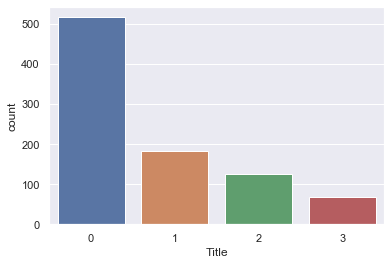

In [62]:
plot = sns.countplot(df["Title"])

কাউন্টপ্লট থেকেও কিন্তু এইটাই বোঝা যাচ্ছে যে প্যাসেঞ্জারদের ভিতরে পুরুষই ছিলেন বেশি । এর পরে ছিলেন অবিবাহিতা মহিলারা এবং পরবর্তীতে বিবাহিতা মহিলারা । 

In [63]:
del df['Name']
del test['Name']

নাম থেকে টাইটেল আলাদা করা শেষ তো এবার আর নাম কলামের দরকার নাই । ২ ডেটাসেট থেকেই ডিলেট করে দিলাম । 

In [64]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,1
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,male,35.0,0,0,373450,8.0500,B96 B98,S,0


In [65]:
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

এবার মহিলা এবং পুরুষদের ০ এবং ১ এর ভ্যালুতে কনভার্ট করে ফেললাম । এটা কিন্তু আগের বারের করা লেবেল এনকোডিংই । কিন্তু এখানে আমি নিজে বলে দিচ্ছি কে কোন নাম্বার পাবে আরকি । 

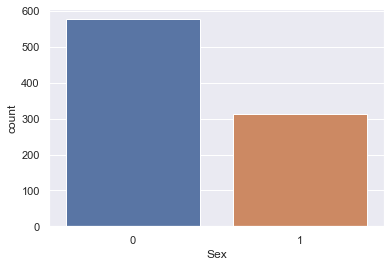

In [66]:
plot = sns.countplot(df["Sex"])

In [67]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

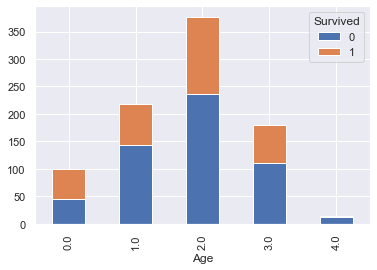

In [68]:
plot = (df
        .groupby(['Age', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

এবার কিন্তু আমরা বয়সের আউটলেয়ার বাদ দেই নি । করেছি কি আসলে? এখানে বয়সকে ৫ ক্যাটাগরিতে ভাগ করেছি । যাতে আমাদের মডেলের বুঝতে সুবিধা হয় কোন বয়সের লোকগুলোকে বেশি গুরুত্ব দেয়া উচিৎ । 

In [69]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,B96 B98,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,B96 B98,S,0


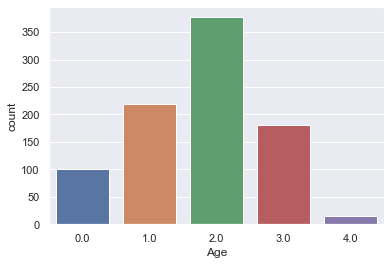

In [70]:
plot = sns.countplot(df["Age"])

বয়সের ক্যাটাগরিতে দেখা যাচ্ছে ২৬-৩৬ বয়সি মানুষ বেশি ছিলো শিপে । 

In [71]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

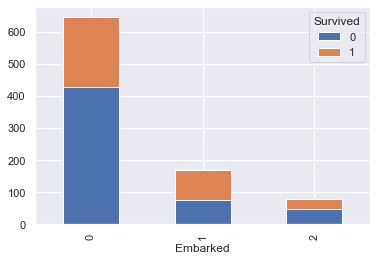

In [72]:
plot = (df
        .groupby(['Embarked', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

এবার পোর্ট গুলিকে নাম্বারে ম্যাপিং করে দিলাম একই ভাবে । এখান থেকে কি বোঝা যায়? S বা সাউথাম্পটন পোর্ট থেকে যারা উঠেছিলেন তারা একটু বিত্তবান ছিলেন । তাই তাদের সারভাইভাল রেটটা বাকিদের চেয়ে বেশি । 

In [73]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,B96 B98,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,B96 B98,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,B96 B98,0,0


In [75]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

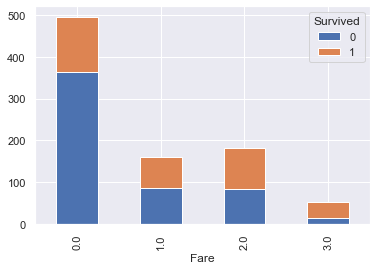

In [76]:
plot = (df
        .groupby(['Fare', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

এখানে ভাড়ার ফিল্ডে কিন্তু প্রচুর আউটলেয়ার ছিলো । কিন্তু এতো আউটলেয়ার যে আপনার উচিৎ হবে না এই আউটলেয়ার বাদ দেয়া । বরঞ্চ আপনি যদি ভাড়াকে ৪ ভাগে ভাগ করে ফেলেন তাহলে মডেল আর বায়াসড হবে না । সে ভাড়ার ফিল্ড থেকে ইজিলি লার্ন করেত পারবে যেহেতু মাত্র ৪ ধরনের ভাড়া হতে পারে । এখানেও দেখা যাচ্ছে নিম্নবিত্তরা সংখ্যায় অনেক থাকলেও বেচেছে অনুপাতে বাকিদের চেয়ে কম । যারা বেঁচেছে তাদের প্রায় সবই বাচ্চা আর মা হবে । 

In [77]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,B96 B98,0,0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,B96 B98,0,1
3,4,1,1,1,2.0,1,0,113803,2.0,C123,0,2
4,5,0,3,0,2.0,0,0,373450,0.0,B96 B98,0,0


In [78]:
df.Cabin.value_counts()

B96 B98        691
C23 C25 C27      4
G6               4
F2               3
E101             3
              ... 
C111             1
C91              1
C45              1
B78              1
F E69            1
Name: Cabin, Length: 147, dtype: int64

In [80]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

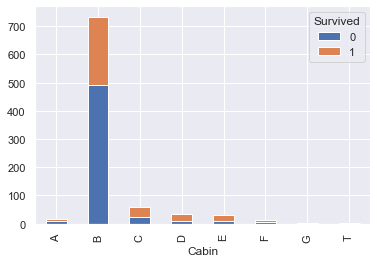

In [81]:
plot = (df
        .groupby(['Cabin', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

কেবিনের হিসাবে আসি এবার । কেবিনের কিন্তু আমাদের ফুল ডেটা লাগবে না । শুধু লাগবে কোন ক্যারেক্টার দিয়ে শুরু । কেন লাগবে ?
আসলে কেবিনের এই শুরুর ক্যারেক্টার দিয়েই বুঝতে পারবেন যে কেবিনটি কত তলায় ছিলো । নিচের তালার লোকেরা বেশি মারা গেছে যেহেতু নিচ থেকে ডুবতে শুরু করেছে শিপটি । তো বুঝাই যাচ্ছে হিসেব ঠিক আছে । উপরের তালার দিকের লোকজনই বেশি বেচেছে । জি আর টি তালায় কেউ বাঁচেই নি ! 
বুঝলেন এবার ফিচার ইঞ্জিনিয়ারিং কাকে বলে? আমরা যে এখানে বুঝে নিলাম নিচের তালার দিক লোক বেশি মরেছে এই নলেজটাকে বলে ডোমেইন নলেজ । ফিচার ইঞ্জিনিয়ারিংএ এরকম ডোমেইন নলেজ অনেক দরকার । 

In [82]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

যথারীতি আমরা ম্যাপিং করলাম কেবিন নাম্বারকে । 

In [83]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

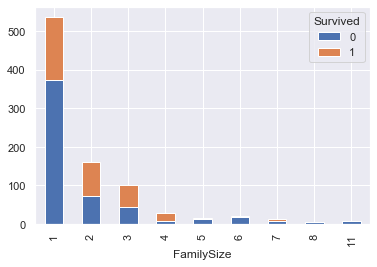

In [84]:
plot = (df
        .groupby(['FamilySize', 'Survived'])
        .size()
        .unstack()
        .plot
        .bar(stacked=True))

এখানে কি করেছি? এখানে দেখেছি ফ্যামিলি মেম্বারের হিসেবটা । মনে আছে আমরা দেখেছিলাম যার সাথে বাবা-মা আছে বা ভাই বোন বেশি তার বাঁচার চান্স বেশি ছিলো । এখানেও দেখেন যাদের ফ্যামিলি মেম্বার বেশি তাদের কিন্তু বাকিদের তুলনায় বেঁচে থাকার চান্সটা অনেক বেশি ছিলো । তবে আবার দেখা যাচ্ছে ৫ বা তার অধিকের ক্ষেত্রে হিসেবটা উলটো । তো এখানে আমরা ২ টা ফিচারকে একটা ফিচারে কনভার্ট করে ফেলেছি । আপনাদের কাছে প্রশ্ন শেষে ১ কেন যোগ করলাম? এটা আমি বলবো না । আপনারা বের করেন । 

In [85]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

ফ্যামিলিকে ম্যাপিং করে নিলাম । 

In [86]:
features_drop = ['Ticket', 'SibSp', 'Parch']
df = df.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
df = df.drop(['PassengerId'], axis=1)

টিকেট, ভাইবোন, বাবা-মা এই তিনটা ফিল্ড থেকে যা যা নেয়ার নিয়ে নিয়েছি । এবার এদের ফেলে দেই । কারণ এদের আর কাজ নাই । এখানে কলাম ড্রপ করার আরেকটা নিয়ম জেনে নিলেন কিন্তু । 

In [87]:
train_data = df.drop('Survived', axis=1)
target = df['Survived']
train_data.shape, target.shape

((891, 8), (891,))

এবার আমরা ক্রস ভ্যালিডেশনের জন্য এখানে কি করেছি ? ট্রেইন ডেটাসেট থেকে Survived বাদে বাকি ডেটাগুলো নিয়েছি train_data তে । আর target এ নিয়েছি শুধু Survived কলামটি । এবার এই খানে ট্রেইনডেটা দিয়ে মডেলকে ট্রেইন করবো এবং এইটা দিয়েই ক্রস ভ্যালিডেশন করবো । টেস্ট ডেটাসেটে হাতই দেবো না এখন ।  

In [88]:
train_data.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,0.4,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,0.4,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,0.4,0,0,0.0


In [89]:
# Importing Classifier Modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np

এখানে এবার ডিসিশন ট্রি এর সাথে র‍্যান্ডম ফরেস্ট ও ইম্পোর্ট করে নিলাম । 

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       891 non-null    float64
 6   Embarked    891 non-null    int64  
 7   Title       891 non-null    int64  
 8   FamilySize  891 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 62.8 KB


In [91]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

KFold কি? KFold এর কাজ হচ্ছে আমাদের এইযে ট্রেইন্ডেটা আছে তাকে সে K সংখ্যক বার ভাগ করে করে টেস্ট করবে । একটা এক্সাম্পল দেই । 
ধরেন আমার ডেটা আছে, 
#১,২,৩,৪,৫,৬,৭,৮,৯,১০
#এবার আমাদের K এর ভ্যালু ধরেন ৫ ।
#তো ১ম বার সে করলো কি মডেল ট্রেইনের জন্য রাখলো,
#৩,৪,৫,৬,৭,৮,৯,১০
#আর টেস্ট করার জন্য রাখলো ১,২ কে ।
#এবার ২য় বারে সে কি করবে?
#১,২,৫,৬,৭,৮,৯,১০ কে রাখবে ট্রেইনের জন্য আর 
#৩,৪ কে রাখবে টেস্টের জন্য । 
#এভাবে সে প্রতিবার আলাদা আলাদা টেস্ট সেট আর ট্রেইনসেট দিয়ে ভ্যালিডেশন করবে । 
#এটাই হলো ক্রস ভ্যালিডেশন । অর্থাৎ এক ডেটাসেট দিয়েই নানান ভাবে মডেলকে লার্ন করানো । 
#cross_val_score এর কাজ হচ্ছে এই ক্রস ভ্যালিডেশনগুলোর একুরেসি চেক করা । 

In [92]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.83146067 0.78651685 0.7752809  0.84269663 0.78651685
 0.86516854 0.80898876 0.73033708 0.79775281]


তো এখানে আমরা দেখতে পাচ্ছি একেকবার একেক রকম একুরেসি দিচ্ছে সে । গড় একুরেসি কিরকম হয় দেখে নেই । 

In [93]:
# decision tree Score
round(np.mean(score)*100, 2)

79.91

In [94]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.77777778 0.80898876 0.83146067 0.78651685 0.86516854 0.79775281
 0.85393258 0.82022472 0.76404494 0.80898876]


র‍্যান্ডম ফরেস্টের ক্ষেত্রেও একই ভাবে একুরেসি দেখি । এবং দেখি যে এই দুই মডেলে কে বেটার করলো । 

In [95]:
# Random Forest Score
round(np.mean(score)*100, 2)

81.15

র‍্যান্ডম ফরেস্ট বেশি ভোট পেয়ে জয়যুক্ত হয়ছে । তাই আমরা সাবমিশনের জন্য তাকেই চুজ করলাম । 

In [96]:
clf = RandomForestClassifier(n_estimators=13)
clf.fit(train_data, target)
test_data = test.drop("PassengerId", axis=1).copy()
prediction = clf.predict(test_data)


সাবমিশন ফাইল রেডি করলাম । এবার ক্রিয়েট করে সাবমিট করি । 

In [43]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('Pred4.csv', index=False)

কি আসলো রেজাল্ট? একটু কি উন্নতি হয়েছে? 
<img src="pred4.jpg">

আমাদের নেক্সট কি কি মাথায় রাখা যেতে পারে?
১। মিসিং ভ্যালু কলামের মেডিয়ান বা মোড দিয়ে ফিক্স না করে তার সাথে এটাও দেখা যেতে পারে অন্য কলামের 
সম্পর্ক কেমন । তার উপর ভিত্তি করে ফিক্স করা যেতে পারে । যেমন ধরেন, 
কেবিনের যেসব মিসিং ভ্যালু আছে তা হিসেব করতে পারি ঐ কেবিন কোন ক্লাসে আছে তার উপর বেস করে । কিংবা ভাড়ার সাথে বেস করে । 

২। আউটলেয়ার ফিক্স করা যেতে পারে । 

৩। আমাদের খুব রিলেটেড ফিচার যেমন বয়স, জেন্ডার ইত্যাদি ফিল্ডে ওয়েট সেট করে দেয়া । মানে মডেলকে বলে দিলাম যে এদের দিকে বেশি নজর দিবে । 

৪। অন্য কোন মডেল চুজ করা । লজিস্টিক রিগ্রেসন, কে নিয়ারেস্ট নেইবর, কিংবা নিউরাল নেটওয়ার্ক । 

ট্রাই করে দেখবেন নাকি?